In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import flax
import flax.linen as nn
import optax

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

from lensinglognormal import lensingLogNormal, make_power_map, Pk_fn

2024-03-14 10:45:12.792467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


gpu


## Defining the model

In [7]:
sigma_e = 0.2
gal_per_arcmin2 = 30
map_size = 10
N = 32

In [8]:
from functools import partial 

model_log_normal = partial(
    lensingLogNormal, 
    N=N, 
    map_size=map_size, 
    gal_per_arcmin2=gal_per_arcmin2, 
    sigma_e=sigma_e, 
    model_type="lognormal"
)

In [9]:
from numpyro.handlers import seed, trace, condition

# Create our fiducial observations
fiducial_model = condition(model_log_normal, {'theta': [0.3, 0.8]})
model_trace = trace(seed(fiducial_model, jax.random.PRNGKey(42))).get_trace() 
m_data = model_trace['x']['value']
ia_fid = model_trace['ia']['value']
init_values = {k: jnp.array(model_trace[k]['value']) for k in ['z', 'theta', 'ia']}

/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/pbs/home/j/jzeghal/.local/lib/python3.8/site-packag

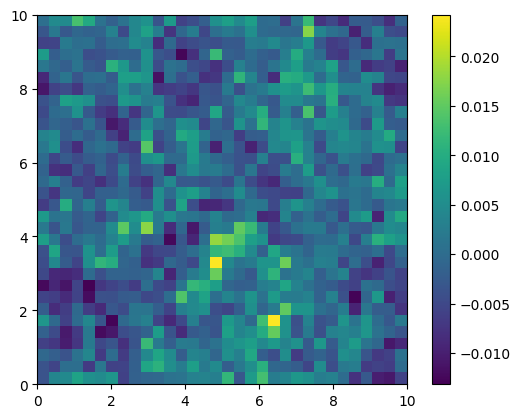

In [10]:
import matplotlib.pyplot as plt
plt.imshow(m_data, extent=(0,10,0,10))
plt.colorbar()

## Get constrain on omega_c and sigma_8

In [13]:
nb_samples_mcmc = 10_000

In [ ]:
from numpyro.handlers import condition, reparam, seed, trace
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

observed_model = condition(model_log_normal, {"x": m_data})

def config(x):
    if type(x["fn"]) is dist.TransformedDistribution:
        return TransformReparam()
    elif (
        type(x["fn"]) is dist.Normal or type(x["fn"]) is dist.TruncatedNormal or type(x["fn"]) is dist.Independent
    ) and ("decentered" not in x["name"]) and ("x" not in x["name"]):
        return LocScaleReparam(centered=0)
    else:
        return None
    
observed_model_reparam = reparam(observed_model, config=config)
            
nuts_kernel = numpyro.infer.NUTS(
    model=observed_model_reparam,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    max_tree_depth=4,
    step_size=1e-2
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=nb_samples_mcmc,
    num_chains=1,
    chain_method='vectorized',
    progress_bar=True
)

mcmc.run(jax.random.PRNGKey(86))
posterior_mcmc_from_exact_model = mcmc.get_samples()

  0%|          | 0/10200 [00:00<?, ?it/s]/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/pbs/home/j

In [30]:
jnp.save('posterior_mcmc_from_exact_model.npy', jnp.array(posterior_mcmc_from_exact_model['theta']))

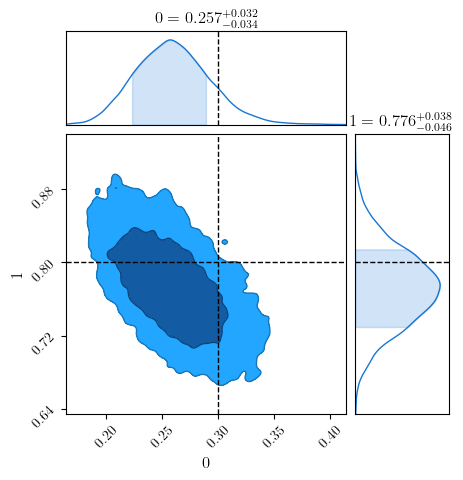

In [31]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(
    jnp.array(posterior_mcmc_from_exact_model['theta']),
    name='Exact model'
)

fig = c.plotter.plot(figsize=1.5, truth=[0.3,0.8])

In [32]:
gaussian_model = partial(
    lensingLogNormal, 
    N=N, 
    map_size=map_size, 
    gal_per_arcmin2=gal_per_arcmin2, 
    sigma_e=sigma_e, 
    model_type="gaussian", 
    with_ia=False
)

In [ ]:
from numpyro.handlers import condition, reparam, seed, trace

observed_model = condition(gaussian_model, {"x": m_data})

def config(x):
    if type(x["fn"]) is dist.TransformedDistribution:
        return TransformReparam()
    elif (
        type(x["fn"]) is dist.Normal or type(x["fn"]) is dist.TruncatedNormal or type(x["fn"]) is dist.Independent
    ) and ("decentered" not in x["name"]) and ("x" not in x["name"]):
        return LocScaleReparam(centered=0)
    else:
        return None
    
observed_model_reparam = reparam(observed_model, config=config)
            
nuts_kernel = numpyro.infer.NUTS(
    model=observed_model_reparam,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    max_tree_depth=4,
    step_size=1e-2
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=nb_samples_mcmc,
    num_chains=1,
    chain_method='vectorized',
    progress_bar=True
)

mcmc.run(jax.random.PRNGKey(86))
posterior_mcmc_from_exact_model = mcmc.get_samples()

/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/pbs/home/j/jzeghal/.local/lib/python3.8/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/pbs/home/j/jzeghal/.local/lib/python3.8/site-packag

In [ ]:
jnp.save(
    'posterior_mcmc_from_biased_model.npy', 
    posterior_mcmc_from_biased_model['theta']
)

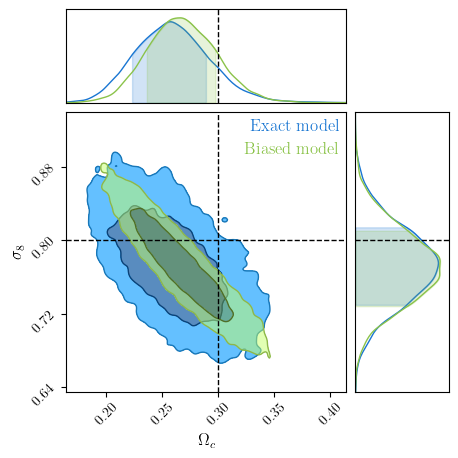

In [60]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(
    posterior_mcmc_from_exact_model['theta'],
#     kde = 1,
    name='Exact model', 
    shade_alpha=0.7, parameters=['$\Omega_c$','$\sigma_8$']
)
c.add_chain(
    posterior_mcmc_from_biased_model['theta'],
    name='Biased model', 
    shade_alpha = 0.5, 
    parameters=['$\Omega_c$','$\sigma_8$']
)
fig = c.plotter.plot(figsize=1.5, truth=[0.3,0.8])

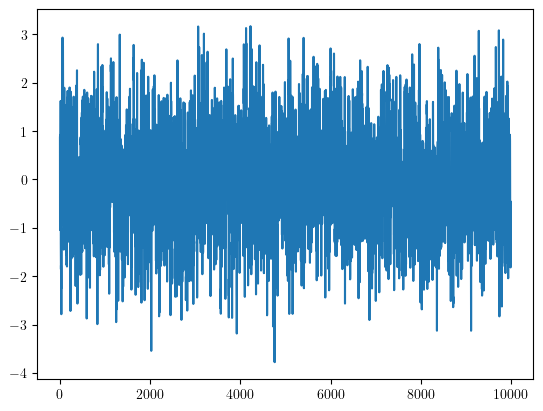

In [49]:
plt.plot(posterior_mcmc_from_biased_model['ia'])

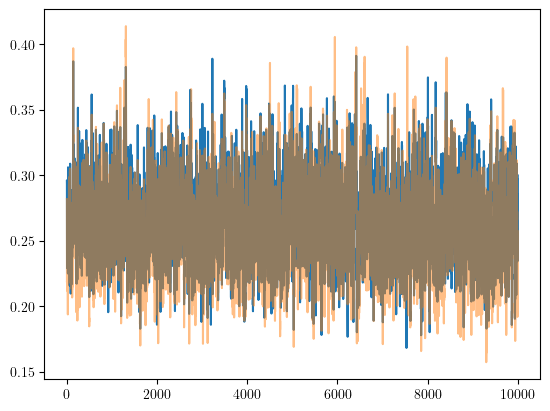

In [55]:
plt.plot(posterior_mcmc_from_biased_model['theta'][:,0])
plt.plot(posterior_mcmc_from_exact_model['theta'][:,0], alpha =0.5)

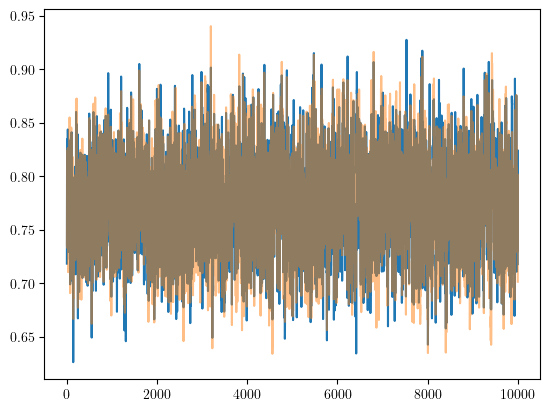

In [56]:
plt.plot(posterior_mcmc_from_biased_model['theta'][:,1])
plt.plot(posterior_mcmc_from_exact_model['theta'][:,1], alpha =0.5)